In [1]:
import anndata as ad
from anndata.experimental.pytorch import AnnLoader
import torch
import torch.optim
import torch.nn as nn
import numpy as np
import time

In [2]:
import os
os.getcwd()


'/zhome/af/a/221977'

In [10]:
!pip install 'scanpy[leiden]'
import scanpy as sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.7 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
      Traceback (most recent call last):
        File "/zhome/af/a/221977/anndata_venv/lib/python3.14/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "/zhome/af/a/221977/anndata_venv/lib/python3.14/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "/zhome/af/a/221977/anndata_venv/lib/python3.14/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 143, in get_requires_for_build_wheel
   

ModuleNotFoundError: No module named 'scanpy'

# Import

In [3]:
t0 = time.time()
genes_df = ad.read_h5ad("/work3/s193518/scIsoPred/data/bulk_processed_genes.h5ad")
t1 = time.time()

print('loaded df in: ', f'{t1-t0:.2f}', ' seconds')

loaded df in:  231.40  seconds


In [4]:
t0 = time.time()
isoform_df = ad.read_h5ad("/work3/s193518/scIsoPred/data/bulk_processed_transcripts.h5ad")
t1 = time.time()

print('loaded df in: ', f'{t1-t0:.2f}', ' seconds')

loaded df in:  330.96  seconds


In [5]:
# inspecting dimensions
print('number of genes = ', genes_df.n_vars)
print('number of isoforms = ', isoform_df.n_vars)
print('proportion =  ', f'1 gene : {isoform_df.n_vars/genes_df.n_vars:.1f} isoforms')


number of genes =  45263
number of isoforms =  162009
proportion =   1 gene : 3.6 isoforms


In [6]:
genes_df.n_obs == isoform_df.n_obs

True

In [7]:
isoform_df.var

,gene_name,gene_id
transcript_id,,
ENST00000456328,DDX11L1,ENSG00000223972.5
ENST00000488147,WASH7P,ENSG00000227232.5
ENST00000461467,FAM138A,ENSG00000237613.2
ENST00000641515,OR4F5,ENSG00000186092.7
ENST00000466430,ENSG00000238009,ENSG00000238009.6
...,...,...
ENST00000361681,MT-ND6,ENSG00000198695.2
ENST00000387459,MT-TE,ENSG00000210194.1
ENST00000361789,MT-CYB,ENSG00000198727.2


In [8]:
genes_df.X[:10,:10].toarray()

array([[ 42, 285,  17,   0,  78,   0, 166, 467, 107,  66],
       [  1,  42,   4,   0,  37,  32,  38, 165,  10,   4],
       [ 11,  61,  15,   1,  28,   0,  10,  19,   8,   0],
       [  0,  17,   0,   0,  21,   1,   6,  25,   5,   4],
       [  1, 231,   0,   0,  77,   0,   4,  80,   6,   0],
       [  0,  11,   4,   0,  69,  41,  67, 476, 104,  55],
       [  0,   0,   0,   0,   2,   6,   2,   0,   2,   0],
       [ 60, 366,  23,   0, 116,   0, 179, 892, 186,   0],
       [ 31, 498,  38,   4, 188,  16, 175,  28,   3,   0],
       [  0,  19,   5,   0,  12,   0,   2,   0,   0,   1]], dtype=uint32)

# Derive representations

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
genes_X = torch.from_numpy(genes_df.X.toarray()).int()
isoforms_Y = torch.from_numpy(isoform_df.X.toarray()).int()

In [ ]:
genes_pca = pca_model.fit_transform(genes_X)#.to_array())

In [ ]:
isoform_pca = pca_model.fit_transform(isoforms_Y)#.to_array())

In [ ]:
import matplotlib.pyplot as plt

plt.figure(6,6)
plt.scatter(genes_pca[:,0], alpha=0.3, s=3,c='darkcyan')
plt.scatter(isoform_pca[:,0],alpha=0.3, s=3,c='darkred')

# Training

In [10]:
from torch.utils.data import Dataset, DataLoader

## Define a custom dataset class that returns proper X, y's

In [11]:
genes_X = torch.from_numpy(genes_df.X.toarray()).float()
isoforms_Y = torch.from_numpy(isoform_df.X.toarray()).float()

In [18]:
class GenesDataset(Dataset):
    
    def __init__(self, genes_X, isoforms_Y, log_transform=True, normalize=True, axis='feature'):
        """
        Arguments:
            genes_X (torch.Tensor): gene expression matrix [n_samples, n_genes]
            isoforms_Y (torch.Tensor): isoform abundance matrix [n_samples, n_isoforms]
            log_transform (bool): whether to apply log transform with pseudocount. Default = True
        """
        self.genes_X = genes_X
        self.isoforms_Y = isoforms_Y    
        
        if log_transform:
            # add (x + pseudocount) and log transform
            self.genes_X = torch.log1p(genes_X)  
            self.isoforms_Y = torch.log1p(isoforms_Y)
            
        if normalize:
            if axis == "feature":  # normalize per gene/isoform across samples
                genes_mean = genes_X.mean(dim=0, keepdim=True)
                genes_std  = genes_X.std(dim=0, keepdim=True) + 1e-8
                genes_X = (genes_X - genes_mean) / genes_std

                iso_mean = isoforms_Y.mean(dim=0, keepdim=True)
                iso_std  = isoforms_Y.std(dim=0, keepdim=True) + 1e-8
                isoforms_Y = (isoforms_Y - iso_mean) / iso_std

            elif axis == "sample":  # normalize per cell/sample
                genes_mean = genes_X.mean(dim=1, keepdim=True)
                genes_std  = genes_X.std(dim=1, keepdim=True) + 1e-8
                genes_X = (genes_X - genes_mean) / genes_std

                iso_mean = isoforms_Y.mean(dim=1, keepdim=True)
                iso_std  = isoforms_Y.std(dim=1, keepdim=True) + 1e-8
                isoforms_Y = (isoforms_Y - iso_mean) / iso_std

            else:
                raise ValueError("axis must be either 'feature' or 'sample'")

    def __len__(self):
        return self.genes_X.size(0)

    def __getitem__(self, idx):

        return self.genes_X[idx].unsqueeze(0), self.isoforms_Y[idx].unsqueeze(0)
        


my_dataset = GenesDataset(genes_X, isoforms_Y)

In [ ]:
# Do a train-test split on the data

seed = 42
test_size = 0.1

np.random.seed(seed)
n_obs = genes_df.n_obs
indices = np.random.permutation(n_obs)

test_count = int(n_obs * test_size)
test_idx = indices[:test_count]
train_idx = indices[test_count:]

In [19]:
### prova subset of the fulldataframe for time reasons

# Do a train-test split on the data

seed = 42
test_size = 0.1

np.random.seed(seed)
n_obs = genes_df.n_obs
indices = np.random.permutation(n_obs)

test_count = 200
test_idx = indices[:test_count]
train_idx = indices[test_count:2000]

In [20]:
train_dataset = GenesDataset(
    genes_X[train_idx], 
    isoforms_Y[train_idx])
test_dataset = GenesDataset(
    genes_X[test_idx], 
    isoforms_Y[test_idx])

In [21]:
assert 2000 == len(train_dataset) + len(test_dataset)

## Dataloader

In [22]:
batch_size = 64

# Make data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    # num_workers=4 # maybe i only get one process on the interactive shared compute node.
)


validation_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    # num_workers=4 # maybe i only get one process on the interactive shared compute node.
    # collate_fn=collate_fn)#, drop_last=False
)

In [23]:
for idx, (inputs, targets) in enumerate(train_loader):
    print(idx)
    print(inputs.shape)
    print(targets.shape)
    if idx==3:
        break

0
torch.Size([64, 1, 45263])
torch.Size([64, 1, 162009])
1
torch.Size([64, 1, 45263])
torch.Size([64, 1, 162009])
2
torch.Size([64, 1, 45263])
torch.Size([64, 1, 162009])
3
torch.Size([64, 1, 45263])
torch.Size([64, 1, 162009])


## define Training loop



In [ ]:
!pip install scikit-learn
!pip install matplotlib

In [55]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.25))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

In [56]:
use_cuda = torch.cuda.is_available()
ratio = 0.5
hidden_dims = [2048,1024,524,256,128]
model = MLP(genes_df.n_vars, hidden_dims = hidden_dims, out_dim=isoform_df.n_vars)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")
print(genes_df.n_vars/sum(p.numel() for p in model.parameters()))
if use_cuda:
    model.to('cuda')

116.410365 M parameters
0.00038882276505189205


In [57]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode="min"):
        """
        Arguments:
            patience (int): number of epochs to wait after last improvement
            min_delta (float): minimum change to qualify as improvement
            mode (str): "min" to monitor decreasing metric (e.g., loss), "max" for increasing metric
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
            return False

        improvement = (current_score < self.best_score - self.min_delta) if self.mode == "min" else (current_score > self.best_score + self.min_delta)

        if improvement:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=10, min_delta=1e-4, mode="min")

In [73]:
# define train_model()
import torch
from tqdm import tqdm
import numpy as np

def pearson_corr(x, y):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    return torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-8)

def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs, scheduler, device="cpu"):
    model.to(device)

    train_losses_array = []
    val_losses_array = []
    train_corr_array = []
    val_corr_array = []
    

    for epoch in range(num_epochs):
        # ----- TRAINING -----
        model.train()
        running_loss = 0.0
        running_corr = 0.0
        total = 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            # Forward pass
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass
            
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                batch_corr = pearson_corr(outputs.flatten(), targets.flatten()).item()
                running_corr += batch_corr * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_corr = running_corr / total
        train_losses_array.append(train_loss)
        train_corr_array.append(train_corr)

        # ----- VALIDATION -----
        model.eval()
        val_loss = 0.0
        val_corr = 0.0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

                batch_corr = pearson_corr(outputs.flatten(), targets.flatten()).item()
                val_corr += batch_corr * inputs.size(0)
                total_val += inputs.size(0)

        val_loss /= total_val
        val_corr /= total_val
        val_losses_array.append(val_loss)
        val_corr_array.append(val_corr)

        scheduler.step(val_loss)

        if early_stopping(val_loss):
            print(f"Stopping early at epoch {epoch+1}")
            break

        # ----- LOGGING -----
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_corr:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_corr:.4f}")

    print("✅ Finished training.")
    return train_losses_array, train_corr_array, val_losses_array, val_corr_array


In [74]:
t0 = time.time()
num_epochs = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()  # or L1Loss for MAE
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
train_losses_array, train_corr_array, val_losses_array, val_corr_array = train_model(model, 
                                                                                     train_loader, 
                                                                                     validation_loader, 
                                                                                     optimizer, 
                                                                                     loss_fn, 
                                                                                     num_epochs, 
                                                                                     scheduler, 
                                                                                     device)
t1 = time.time()

Epoch 1/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.13it/s]


Epoch [1/500] Train Loss: 3.3229 | Train Acc: 0.6243 | Val Loss: 2.6891 | Val Acc: 0.7053


Epoch 2/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.25it/s]


Epoch [2/500] Train Loss: 2.4858 | Train Acc: 0.7083 | Val Loss: 2.3246 | Val Acc: 0.7395


Epoch 3/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.58it/s]


Epoch [3/500] Train Loss: 2.3241 | Train Acc: 0.7270 | Val Loss: 2.2627 | Val Acc: 0.7451


Epoch 4/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.59it/s]


Epoch [4/500] Train Loss: 2.2880 | Train Acc: 0.7321 | Val Loss: 2.2518 | Val Acc: 0.7475


Epoch 5/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.63it/s]


Epoch [5/500] Train Loss: 2.2844 | Train Acc: 0.7326 | Val Loss: 2.2491 | Val Acc: 0.7475


Epoch 6/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.56it/s]


Epoch [6/500] Train Loss: 2.2805 | Train Acc: 0.7333 | Val Loss: 2.2492 | Val Acc: 0.7468


Epoch 7/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.81it/s]


Epoch [7/500] Train Loss: 2.2783 | Train Acc: 0.7336 | Val Loss: 2.2491 | Val Acc: 0.7466


Epoch 8/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.97it/s]


Epoch [8/500] Train Loss: 2.2712 | Train Acc: 0.7343 | Val Loss: 2.2548 | Val Acc: 0.7465


Epoch 9/500: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.87it/s]


Epoch [9/500] Train Loss: 2.2630 | Train Acc: 0.7354 | Val Loss: 2.2519 | Val Acc: 0.7469


Epoch 10/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.85it/s]


Epoch [10/500] Train Loss: 2.2610 | Train Acc: 0.7358 | Val Loss: 2.2495 | Val Acc: 0.7474


Epoch 11/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.57it/s]


Epoch [11/500] Train Loss: 2.2656 | Train Acc: 0.7354 | Val Loss: 2.2460 | Val Acc: 0.7478


Epoch 12/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.23it/s]


Epoch [12/500] Train Loss: 2.2610 | Train Acc: 0.7357 | Val Loss: 2.2481 | Val Acc: 0.7471


Epoch 13/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.71it/s]


Epoch [13/500] Train Loss: 2.2618 | Train Acc: 0.7357 | Val Loss: 2.2470 | Val Acc: 0.7471


Epoch 14/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.70it/s]


Epoch [14/500] Train Loss: 2.2663 | Train Acc: 0.7350 | Val Loss: 2.2460 | Val Acc: 0.7474


Epoch 15/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.74it/s]


Epoch [15/500] Train Loss: 2.2567 | Train Acc: 0.7362 | Val Loss: 2.2471 | Val Acc: 0.7471


Epoch 16/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.74it/s]


Epoch [16/500] Train Loss: 2.2526 | Train Acc: 0.7369 | Val Loss: 2.2475 | Val Acc: 0.7471


Epoch 17/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.75it/s]


Epoch [17/500] Train Loss: 2.2533 | Train Acc: 0.7368 | Val Loss: 2.2461 | Val Acc: 0.7469


Epoch 18/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.80it/s]


Epoch [18/500] Train Loss: 2.2520 | Train Acc: 0.7368 | Val Loss: 2.2492 | Val Acc: 0.7471


Epoch 19/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 23.13it/s]


Epoch [19/500] Train Loss: 2.2527 | Train Acc: 0.7368 | Val Loss: 2.2470 | Val Acc: 0.7474


Epoch 20/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.81it/s]


Epoch [20/500] Train Loss: 2.2545 | Train Acc: 0.7366 | Val Loss: 2.2467 | Val Acc: 0.7471


Epoch 21/500: 100%|█████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.87it/s]


Stopping early at epoch 21
✅ Finished training.


In [75]:
print(f'total training time: {(t1-t0)//60:.0f}m{(t1-t0)%60:.0f}s')

total training time: 0m31s


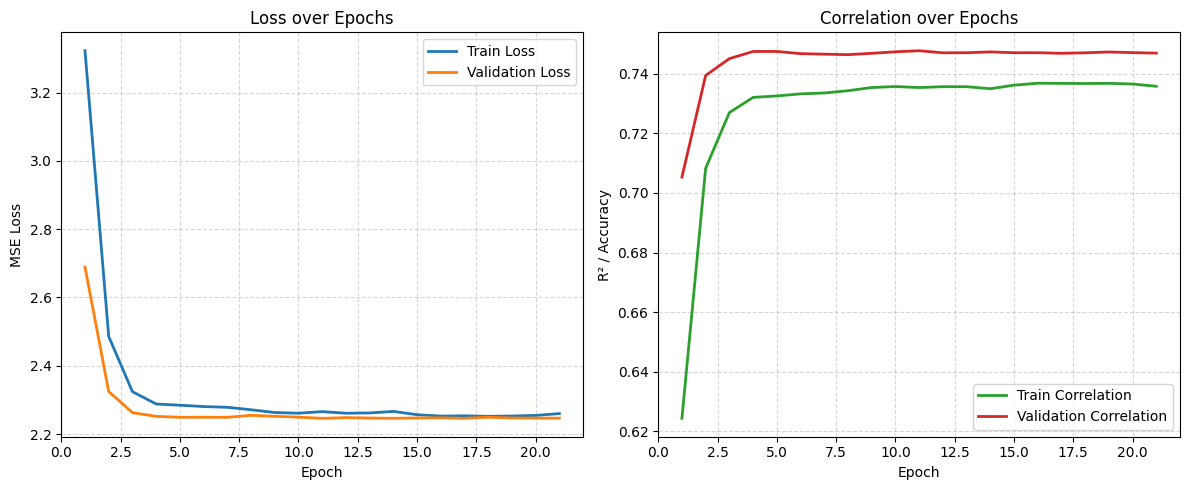

In [78]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_losses_array) + 1)

plt.figure(figsize=(12, 5))

# --- LOSS PLOT ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_array, label='Train Loss', color='tab:blue', linewidth=2)
plt.plot(epochs, val_losses_array, label='Validation Loss', color='tab:orange', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- Correlation PLOT ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_corr_array, label='Train Correlation', color='tab:green', linewidth=2)
plt.plot(epochs, val_corr_array, label='Validation Correlation', color='tab:red', linewidth=2)
plt.title('Correlation over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² / Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()




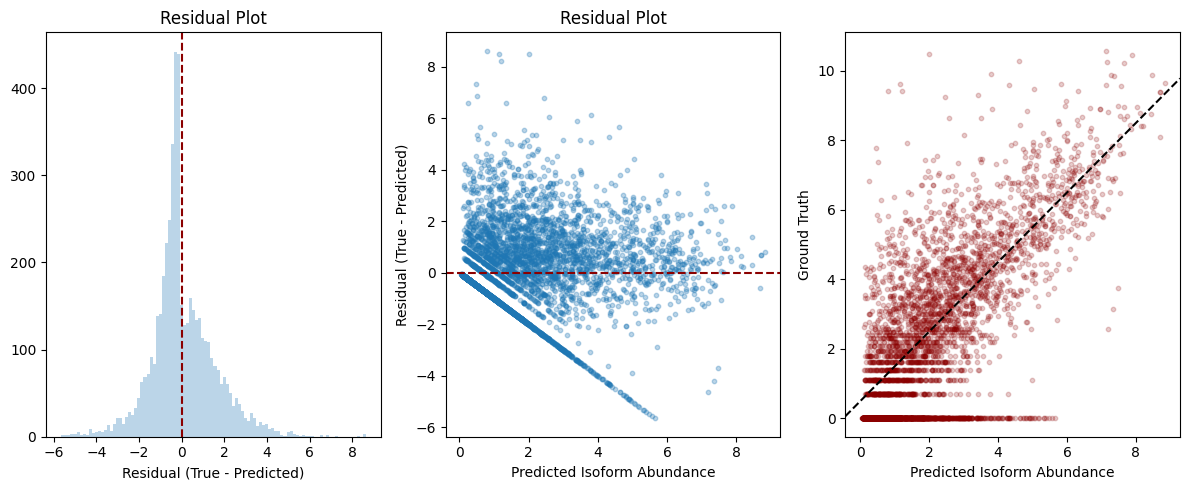

In [82]:
model.eval()
preds_list, targets_list = [], []
# n_points = len(test_dataset)
n_points = 5000

with torch.no_grad():
    for inputs, targets in validation_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        preds_list.append(outputs.cpu())
        targets_list.append(targets.cpu())
        
preds = torch.cat(preds_list).flatten()
targets = torch.cat(targets_list).flatten()

if len(preds) > n_points:
    idx = torch.randperm(len(preds))[:n_points]
    preds = preds[idx]
    targets = targets[idx]

residuals = targets - preds

plt.figure(figsize=(12, 5))



plt.subplot(1, 3, 1)
plt.hist(residuals, alpha=0.3, bins = 100)
plt.axvline(0, color="darkred", linestyle="--")
plt.xlabel("Residual (True - Predicted)")
plt.title("Residual Plot")

plt.subplot(1, 3, 2)
plt.scatter(preds, residuals, alpha=0.3, s=10)
plt.axhline(0, color="darkred", linestyle="--")
plt.xlabel("Predicted Isoform Abundance")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")

plt.subplot(1, 3, 3)
plt.scatter(preds, targets, alpha=0.2, s=10, c='darkred')
plt.axline((0, 0.5), slope=1, color="black", linestyle='--')
plt.xlabel("Predicted Isoform Abundance")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()

In [83]:
outputs.shape

torch.Size([8, 1, 162009])

# TODO
- log transform ✅
    - (-> zscore normalization (?)) ✅
- add pseudocount ✅ 
- map isoform counts to isoform relative abundance (consider var_metadata)
- nchia zio fa cagare sta loss
- Early Stopping



# NOTES (DONE)

- nel MLP c'era originalmente una LayerNorm che ho cambiato con BatchNorm1D causa suggerimento di ChatGPT. Da capire perchè è meglio rispetto a prima (?)
    - lol ma nn funziona
- DropOut increase -> 2.5